In [118]:
import numpy as np
import pandas as pd 
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import collections
from scipy.stats.mstats import zscore

In [119]:
ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImages.pkl"
#ImageList = "/datasets_1/sagarj/BellLabs/Data/mediumImages.pkl"
with open(ImageList , 'rb') as f:
    imgList = pickle.load(f)

In [121]:
imgList[1]

('5140c9f3fdc9f049260026b9',
 {'key': '5140c9f3fdc9f049260026b9',
  'label': 1,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140c9f3fdc9f049260026b9.jpg',
  'trueSkill': [14.917022675126862]})

In [122]:
AMImages = "/datasets/sagarj/streetView/Transform_fringe2/"
#AMImages = "/datasets/sagarj/streetView/Transform_Medium/"

In [123]:
files = os.listdir(AMImages)

In [124]:
files[1].split('_')

['50f4644dfdc9f065f000453c', '0000', '1.24356', '.jpg']

In [125]:
filesMap = {}
for f in files:
    comps = f.strip().split('_')
    filesMap[comps[0]] = {}
    filesMap[comps[0]]['path'] = AMImages + f
    filesMap[comps[0]]['act'] = comps[2]
    filesMap[comps[0]]['changeLabel'] = comps[1][-1]

In [126]:
len(filesMap.keys())

200

In [127]:
for row in imgList:
    if row[1]['key'] in filesMap.keys():
        filesMap[row[1]['key']]['origPath'] = row[1]['path']
        filesMap[row[1]['key']]['label'] = row[1]['label']

In [128]:
filesMap[filesMap.keys()[1]]

{'act': '1.21896',
 'changeLabel': '0',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513e20dafdc9f0358700a2f7.jpg',
 'path': '/datasets/sagarj/streetView/Transform_fringe2/513e20dafdc9f0358700a2f7_0000_1.21896_.jpg'}

In [134]:
#Image(filesMap['513d9f45fdc9f035870086b4']['origPath'])

In [135]:
#Image(filesMap['513d9f45fdc9f035870086b4']['path'])

In [136]:
#filesMap['513d9f45fdc9f035870086b4']['changeLabel']

In [137]:
import caffe
import sys
import os

import random
import numpy as np
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

import cv2


# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

model_root = "/datasets_1/sagarj/BellLabs/caffe_models/places/"

imagenet_mean = model_root + 'places205CNN_mean.binaryproto'

logfile = "../Data/PlacesFeatExtractStreetview.txt"


#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

#Size of images
#IMAGE_WIDTH = 224
#IMAGE_HEIGHT = 224
NCHANNELS = 3
meanR = 105.487823486
meanG = 113.741088867
meanB = 116.060394287

meanMat = np.zeros((NCHANNELS,IMAGE_WIDTH,IMAGE_HEIGHT))
meanMat[0,:,:].fill(meanR)
meanMat[1,:,:].fill(meanG)
meanMat[2,:,:].fill(meanB)

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def predictImage(imgPath , net, transformer):
    

    path = imgPath.strip()
    im = caffe.io.load_image(path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    net.forward()
    #out1 = net.blobs['prob'].data
    out2 = net.blobs['fc7'].data
    #print(out2.shape)
    #out = np.concatenate((out1,out2.reshape(1,-1)),axis =1)
    out = out2
    #print(out.shape)
    return out


    
def getFeatMatrix(DataDict):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    for k in DataDict:
        path = DataDict[k]['origPath'].strip()
        if not os.path.exists(path):
            featArray = np.zeros((1,4096))
        else:
            im = transformer.preprocess('data',caffe.io.load_image(path))
            net.blobs['data'].data[...] = im - meanMat
            net.forward()
            featArray = net.blobs['fc7'].data.copy()
                
        DataDict[k]['placesFeats'] = featArray
    return DataDict

def getPlaces(path):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    path = path.strip()
    if not os.path.exists(path):
        featArray = np.zeros((1,4096))
    else:
        im = transformer.preprocess('data',caffe.io.load_image(path))
        net.blobs['data'].data[...] = im - meanMat
        net.forward()
        featArray = net.blobs['prob'].data.copy()
    return featArray

In [138]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u.flatten(), v2_u.flatten()), -1.0, 1.0))

In [139]:
transformedFilesMap = getFeatMatrix(filesMap)

In [140]:
transformedFilesMap[transformedFilesMap.keys()[151]]

{'act': '0.481246',
 'changeLabel': '1',
 'label': 1,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/51409833fdc9f04926000c57.jpg',
 'path': '/datasets/sagarj/streetView/Transform_fringe2/51409833fdc9f04926000c57_0001_0.481246_.jpg',
 'placesFeats': array([[ 0.03427333,  0.56665087,  0.        , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32)}

# This is an extremely shitty part of the code. The crux is you need the test data in a key : dict{} format where the dict should have a 'origPath' entry with the path of the test image which we are retrevi

In [141]:
with open("../Data/TrainImageListBinary_augmented.txt",'r') as f:
    imagePaths = f.readlines()

In [142]:
sampledpaths = random.sample(imagePaths , 5000)

In [143]:
dataFileMap = {}
for p in sampledpaths:
    path = p.strip().split(',')[0]
    key = path.split('/')[-1].split('.')[0][:-1]
    dataFileMap[key] = {}
    dataFileMap[key]['origPath'] = path

In [144]:
retreivalFileMap = getFeatMatrix(dataFileMap)

# End shitty zone now. the next sections are about matching

In [145]:
from scipy.spatial import distance
distanceMapper = {}
for k in filesMap:
    distanceMapper[k] = {}
    for i in retreivalFileMap:
        #distanceMapper[k][i] = angle_between(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])
        distanceMapper[k][i] = distance.euclidean(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])

In [146]:
len(distanceMapper.keys())

200

In [147]:
#distanceMapper[distanceMapper.keys()[0]]

In [148]:
import operator
top5s = {}
for k in distanceMapper:
    top5s[k]=sorted(distanceMapper[k].items(), key=operator.itemgetter(1))[:5]
    

In [149]:
top5s[top5s.keys()[1]]

[('513d7d15fdc9f035870070da', 18.14544105529785),
 ('51414786fdc9f04926006a8d', 19.247915267944336),
 ('513cb8eafdc9f03587000c7f', 19.39592933654785),
 ('513d2dc8fdc9f0358700251b', 19.9647216796875),
 ('513cb345fdc9f03587000722', 20.135583877563477)]

In [150]:
# index = pd.Series(range(len(filesMap.keys())))
# column = ['key' , 'origPath' ,'XformPath' , 'Top5Keys' , 'Top5Paths']

In [151]:
retreivedDf = {}

In [152]:
for k in filesMap:
    top5Keys = [p[0] for p in top5s[k]]
    top5Paths = [dataFileMap[p[0]]['origPath'] for p in top5s[k]]
    origPath = filesMap[k]['origPath']
    xformPath = filesMap[k]['path']
    retreivedDf[k] = dict()
    retreivedDf[k] = {'key' : k , 'origPath' : origPath ,'XformPath' : xformPath , 'Top5Keys' : [top5Keys] , 'Top5Paths' : [top5Paths]}

In [153]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['513d7d15fdc9f035870070da',
   '51414786fdc9f04926006a8d',
   '513cb8eafdc9f03587000c7f',
   '513d2dc8fdc9f0358700251b',
   '513cb345fdc9f03587000722']],
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/AugImages/513d7d15fdc9f035870070da/513d7d15fdc9f035870070da2.jpg',
   '/work/sagarj/Work/BellLabs/streetview/AugImages/51414786fdc9f04926006a8d/51414786fdc9f04926006a8d1.jpg',
   '/work/sagarj/Work/BellLabs/streetview/AugImages/513cb8eafdc9f03587000c7f/513cb8eafdc9f03587000c7f4.jpg',
   '/work/sagarj/Work/BellLabs/streetview/AugImages/513d2dc8fdc9f0358700251b/513d2dc8fdc9f0358700251b2.jpg',
   '/work/sagarj/Work/BellLabs/streetview/AugImages/513cb345fdc9f03587000722/513cb345fdc9f035870007222.jpg']],
 'XformPath': '/datasets/sagarj/streetView/Transform_fringe2/513e20dafdc9f0358700a2f7_0000_1.21896_.jpg',
 'key': '513e20dafdc9f0358700a2f7',
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513e20dafdc9f0358700a2f7.jpg'}

In [154]:
retreivedDf[retreivedDf.keys()[10]]['Top5Paths'][0]

['/work/sagarj/Work/BellLabs/streetview/PPImages/513f2981fdc9f0358700d3a4.jpg',
 '/work/sagarj/Work/BellLabs/streetview/AugImages/513e1cbbfdc9f035870097f5/513e1cbbfdc9f035870097f54.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/5140d267fdc9f049260032d1.jpg',
 '/work/sagarj/Work/BellLabs/streetview/AugImages/50f5eb4cfdc9f065f00081eb/50f5eb4cfdc9f065f00081eb2.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/51409c9dfdc9f049260011fb.jpg']

In [155]:
# for k in range(len(retreivedDf.keys()[:90])):
#     print retreivedDf[retreivedDf.keys()[k]]['XformPath']

In [156]:
k = 16 #11 #16 #190 16 #15 #114 #54 #40 

In [157]:
retreivedDf[retreivedDf.keys()[k]]['XformPath']

'/datasets/sagarj/streetView/Transform_fringe2/513f2ee0fdc9f0358700dcb8_0000_1.21435_.jpg'

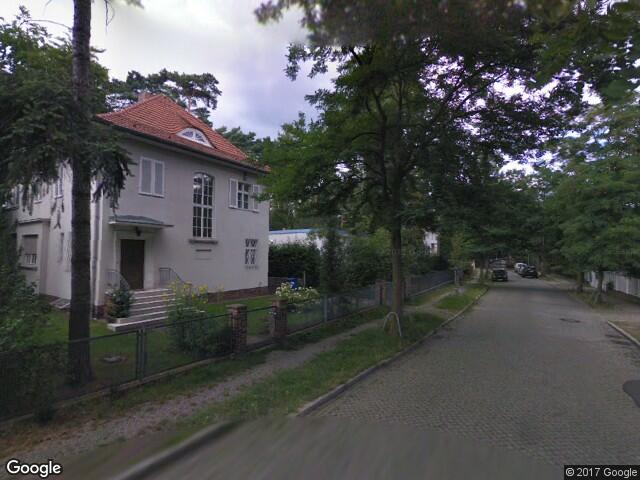

In [158]:
Image(retreivedDf[retreivedDf.keys()[k]]['origPath'])

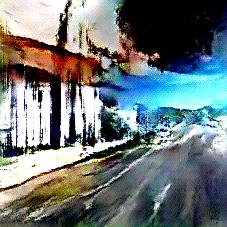

In [159]:
Image(retreivedDf[retreivedDf.keys()[k]]['XformPath'])

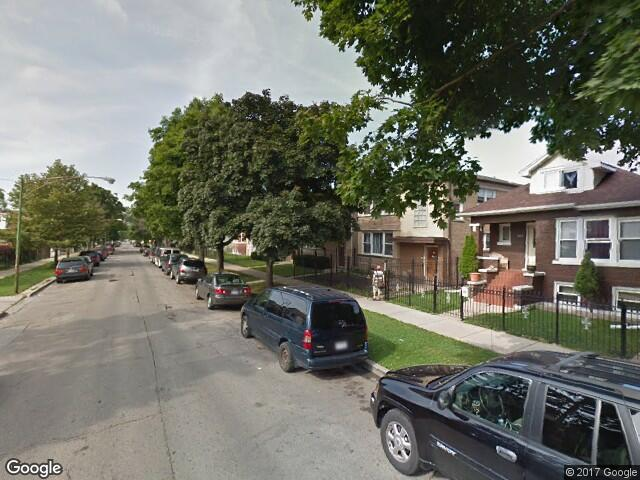

In [160]:
Image(retreivedDf[retreivedDf.keys()[k]]['Top5Paths'][0] [0])

In [161]:
# with open("../Data/retreivedfringeDataframe2.pkl" , 'wb') as f:
#     pickle.dump(retreivedDf , f , protocol=pickle.HIGHEST_PROTOCOL)

# After this step, run the segnet code to extract the right labeled pixel info

In [165]:
# with open('../Data/segnetMedium.pkl', 'rb') as handle:
#     segnetLabels = pickle.load(handle)
with open('../Data/segnetFringe2.pkl', 'rb') as handle:
    segnetLabels = pickle.load(handle)

In [166]:
segnetLabels.keys()

['513d7bd2fdc9f03587006cbc',
 '5140d8fffdc9f04926003b0',
 '513e5f13fdc9f0358700b1b9',
 '50f42babfdc9f065f000155',
 '513cb640fdc9f03587000a0c',
 '513d2d1afdc9f03587002499',
 '51414da3fdc9f04926007644',
 '50f563b5fdc9f065f0005dec',
 '513f2a48fdc9f0358700d4f',
 '5139270a818ede12960010a0',
 '513cb831fdc9f03587000bc',
 '513f2bdafdc9f0358700d787',
 '50f607cbbeb2fed6f80001f0',
 '51422d9bfdc9f04926008c45',
 '513cbfdcfdc9f03587001309',
 '513d9c04fdc9f03587007bd4',
 '513e5bb3fdc9f0358700a906',
 '5142183cfdc9f049260080f',
 '51414e80fdc9f0492600787',
 '50f5ee99fdc9f065f0008f26',
 '5140d97afdc9f04926003c0',
 '51409bfdfdc9f04926001136',
 '51409c9dfdc9f049260011fb',
 '5140b7aafdc9f04926001a82',
 '513f30d4fdc9f0358700df29',
 '50f5eeebfdc9f065f00090f3',
 '51414fd9fdc9f04926007bc',
 '50f55e50fdc9f065f0004ba2',
 '50f42bbcfdc9f065f000171',
 '513d9e19fdc9f035870082c9',
 '513e23befdc9f0358700a6eb',
 '5140c8fbfdc9f049260023d4',
 '50f5ebd3fdc9f065f00085ff',
 '50f5eeaafdc9f065f0008f75',
 '513e1cbbfdc9f03587009

In [167]:
collections.Counter(np.squeeze(segnetLabels[segnetLabels.keys()[200]]).flatten())

Counter({0.0: 8652,
         1.0: 18613,
         2.0: 280,
         4.0: 19,
         5.0: 1571,
         6.0: 143410,
         9.0: 3,
         10.0: 252})

In [168]:
retreivedDf[retreivedDf.keys()[101]]['Top5Keys'][0]

['513d5efefdc9f03587003b34',
 '513d60c1fdc9f03587003d6f',
 '513d9c04fdc9f03587007bd4',
 '513d5ce3fdc9f035870037cb',
 '513d5f17fdc9f03587003b52']

# This section is for calculating normalized ratios of the segnet labels

In [169]:
def normalizeDict(d, denom):
    normDict = {}
    for k in d : 
        normDict[k] = float(d[k])/float(denom)
    return normDict

deltas = {}
for k in retreivedDf:
    xforminfo = retreivedDf[k]['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    deltas[retreivedDf[k]['key']] = {}
    deltas[retreivedDf[k]['key']]['act'] = xformact
    deltas[retreivedDf[k]['key']]['label'] = int(xformLabel[-1])
    
    labels = np.squeeze(segnetLabels[retreivedDf[k]['key']])
    denom = labels.shape[0]*labels.shape[1]
    if retreivedDf[k]['key'] in segnetLabels.keys():
        origLabels = normalizeDict(collections.Counter(np.squeeze(segnetLabels[retreivedDf[k]['key']].flatten())) , denom)
        deltas[retreivedDf[k]['key']]['origLabels'] = {}
        deltas[retreivedDf[k]['key']]['origLabels'] = origLabels
        deltas[retreivedDf[k]['key']]['top5'] = []
        matchList = retreivedDf[k]['Top5Keys'][0]
        for l in matchList:  
            if l in segnetLabels.keys():
                deltas[retreivedDf[k]['key']]['top5'].append(normalizeDict(collections.Counter(np.squeeze(segnetLabels[l].flatten())) , denom))
                
    
    
    
    
    

In [170]:
#deltas

In [171]:
labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [172]:
# deltas[deltas.keys()[100]]['top5']
mean = {}
std = {}

scores = {}
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            if dim not in scores:
                scores[dim] = []
            scores[dim].append(ratios[dim])
#print scores.keys()
for k in scores:
    mean[k] = np.mean(scores[k])
    std[k] = np.std(scores[k])
    
print mean , std

{0.0: 0.19936270715380985, 1.0: 0.13636513254895025, 2.0: 0.0092166832010582012, 3.0: 0.0053962231131475117, 4.0: 0.21052940330856332, 5.0: 0.068419029552715657, 6.0: 0.28418778656067645, 7.0: 0.0012665579280347961, 8.0: 0.028519115890083633, 9.0: 0.054630127241094589, 10.0: 0.0043541221509971507, 11.0: 0.0031688228046594987} {0.0: 0.1323040003596459, 1.0: 0.16498553534005211, 2.0: 0.0075665118079942754, 3.0: 0.0065812379386060169, 4.0: 0.091384311252922207, 5.0: 0.054986051661858215, 6.0: 0.21869678818025415, 7.0: 0.0019884791443096164, 8.0: 0.045171065730180843, 9.0: 0.059231031487430127, 10.0: 0.0087775444370884574, 11.0: 0.0078854077119992899}


In [173]:
# Find update Z scores in deltas:
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            orig = ratios[dim]
            Zscore = (orig - mean[dim])/std[dim]
            ratios[dim] = Zscore

In [267]:
acts = []
action = []
labelDeltas = [[] for i in range(len(labels))]

for k in deltas:
    #if deltas[k]['act'] > 0.1:
    #for c in deltas[k]['top5']:
    if len(deltas[k]['top5']) > 0:
        c = deltas[k]['top5'][0]
        action.append(deltas[k]['label'])
        acts.append(deltas[k]['act'])
        for dims in range(len(labels)):
            delta = 0.0
            if dims in c:
                delta = c[dims]
            labelDeltas[int(dims)].append(delta)

In [268]:
dim = 6

164 164 164


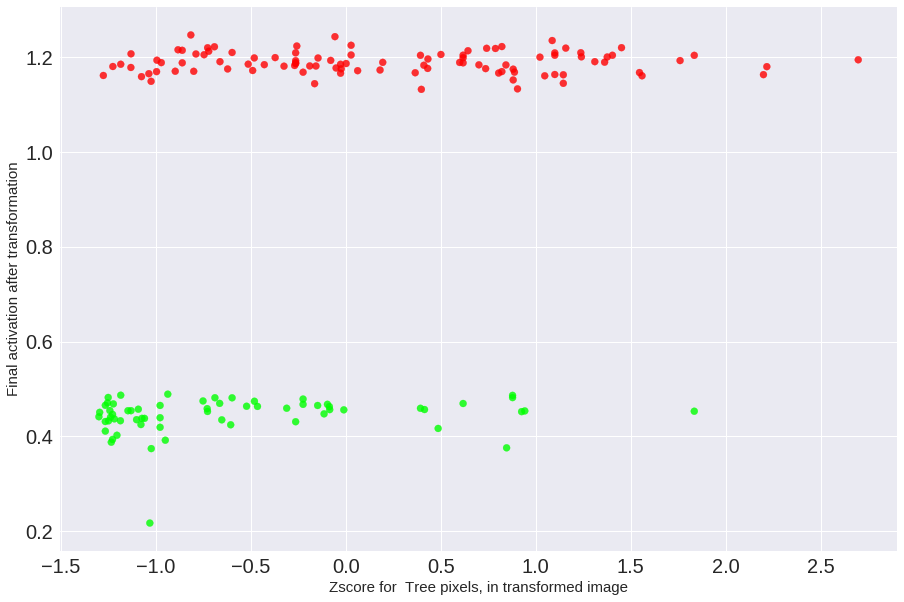

In [269]:
#beautiFied = [labelDeltas[5][i] for i in range
colorPallet=["#FF0000", "#00FF00"]

colors = [colorPallet[action[i]] for i in range(len(action)) if labelDeltas[dim][i] != 0.0 ]
delRatio = [labelDeltas[dim][i] for i in range(len(labelDeltas[dim])) if labelDeltas[dim][i] != 0.0]
delActs = [acts[i] for i in range(len(acts)) if labelDeltas[dim][i] != 0.0 ]
print len(delRatio) , len(delActs) , len(colors)
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 15)
plt.ylabel("Final activation after transformation" , fontsize = 15 )
fig = plt.scatter( delRatio , delActs,  alpha=0.8 , c = colors)
#plt.legend(['Uglified' , 'Beautified'])
plt.show()

In [271]:
len(labelDeltas[0])

165

Extract Beauty and ugly scores for each image based on action (uglified or beautified

In [272]:
beautyDim = []


for j in range(len(labels)):
    beautyDim.append([labelDeltas[j][i] for i in range(len(action)) if (action[i]==1 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==1 ])

In [273]:
uglyDim = []

for j in range(len(labels)):
    uglyDim.append([labelDeltas[j][i] for i in range(len(action)) if(action[i]==0 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==0 ])

In [274]:
print len(beautyDim[11])

46


In [275]:
print labels

['Sky', 'Building', 'Pole', 'Road Marking', 'Road', 'Pavement', 'Tree', 'Sign Symbol', 'Fence', 'Vehicle', 'Pedestrian', 'Bike']


In [278]:
dim = 0

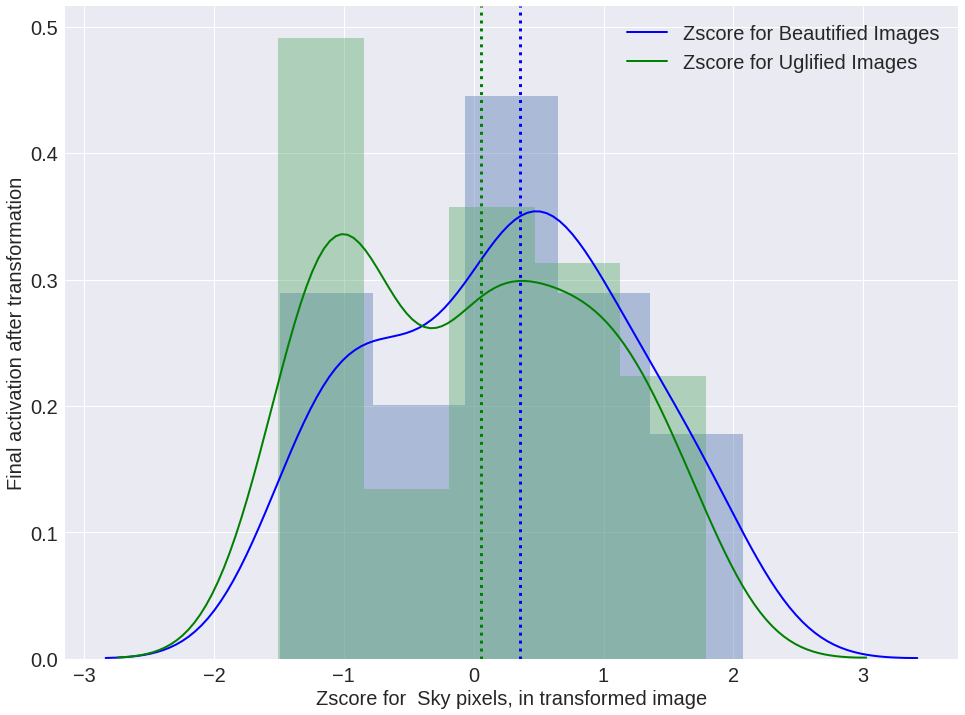

In [279]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautyDim[dim] ,kde_kws={"color": "b", "lw": 2, "label": "Zscore for Beautified Images"})
sns.distplot(uglyDim[dim] , kde_kws={"color": "g", "lw": 2, "label": "Zscore for Uglified Images"})
ax.axvline(x=np.median(beautyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Final activation after transformation" , fontsize = 20 )

In [239]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['513d7d15fdc9f035870070da',
   '51414786fdc9f04926006a8d',
   '513cb8eafdc9f03587000c7f',
   '513d2dc8fdc9f0358700251b',
   '513cb345fdc9f03587000722']],
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/AugImages/513d7d15fdc9f035870070da/513d7d15fdc9f035870070da2.jpg',
   '/work/sagarj/Work/BellLabs/streetview/AugImages/51414786fdc9f04926006a8d/51414786fdc9f04926006a8d1.jpg',
   '/work/sagarj/Work/BellLabs/streetview/AugImages/513cb8eafdc9f03587000c7f/513cb8eafdc9f03587000c7f4.jpg',
   '/work/sagarj/Work/BellLabs/streetview/AugImages/513d2dc8fdc9f0358700251b/513d2dc8fdc9f0358700251b2.jpg',
   '/work/sagarj/Work/BellLabs/streetview/AugImages/513cb345fdc9f03587000722/513cb345fdc9f035870007222.jpg']],
 'XformPath': '/datasets/sagarj/streetView/Transform_fringe2/513e20dafdc9f0358700a2f7_0000_1.21896_.jpg',
 'key': '513e20dafdc9f0358700a2f7',
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513e20dafdc9f0358700a2f7.jpg'}

In [188]:
beautifiedPlaces = []
#beautyOrig = []
uglifiedPlaces = []
#uglyOrig = []c

c1 = 0
c2 = 0
for k in retreivedDf:
    if retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1] == '0':
        #uglyOrig.append(getPlaces(retreivedDf[k]['origPath'])
        c1+=1
        if c1 >= 61:
            continue
        uglifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
    else:
        #beautyOrig.append(getPlaces(retreivedDf[k]['origPath']))
        beautifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
        c2+=1

In [189]:
print "Done" , str(c1) , str(c2)

Done 121 79


In [190]:
with open("../Data/categoryIndex_places205.csv" , 'rb') as f:
    cats = f.readlines()

In [191]:
cats[1]

'/a/airport_terminal 1,,U,L\r\n'

In [192]:
catDict = {}
for c in cats:
    comps = c.strip().split(',')
    idx = comps[0].split(' ')[1]
    lbl = comps[0].split(' ')[0]
    catDict[idx] = {}
    catDict[idx]['label'] = lbl
    catDict[idx]['tnomy'] = comps[-1]


In [193]:
len(catDict)

205

In [194]:
def getTnomyCount(placesProbs,lblDict):
    TnomyCount = {'W' : 0 , 'L': 0 , 'A' : 0 , 'N' : 0}
    labelList = []
    for arr in placesProbs:
        probs = np.squeeze(arr)
        topArgs = probs.argsort()[-5:][::-1]
       
        for i in topArgs:
            key = str(i)
            if lblDict[key]['tnomy'] != '':
                tnomy = lblDict[key]['tnomy']
                TnomyCount[tnomy]+=1
                labelList.append(lblDict[key]['label'])
    return TnomyCount , labelList

In [195]:
beautfiedTnomy, beautifiedLabels = getTnomyCount(beautifiedPlaces,catDict)

In [196]:
#beauOrigTnomy , beauOrigLabels = getTnomyCount(beautyOrig,catDict)

In [197]:
#beautfiedTnomy,beauOrigTnomy

In [198]:
uglifiedTnomy, uglyfiedLabels = getTnomyCount(uglifiedPlaces,catDict)

In [199]:
print beautfiedTnomy , uglifiedTnomy

{'A': 217, 'L': 40, 'W': 90, 'N': 15} {'A': 193, 'L': 14, 'W': 64, 'N': 9}


In [200]:
#uglyOrigTnomy , uglyOrigLabels = getTnomyCount(uglyOrig,catDict)

In [201]:
#uglifiedTnomy, uglyOrigTnomy

In [202]:
#uglyLabels

In [203]:
#beautifiedLabels

In [204]:
common = list(set(uglyfiedLabels).intersection(set(beautifiedLabels)))
#common = list(set(uglyOrigLabels).intersection(set(beauOrigLabels)))

In [205]:
beautySpecific = [i for i in beautifiedLabels if i not in common]
#beautySpecific = [i for i in beauOrigLabels if i not in common]

In [206]:
set(beautySpecific)

{'/a/airport_terminal',
 '/b/bridge',
 '/b/building_facade',
 '/d/dam',
 '/d/dock',
 '/g/garbage_dump',
 '/g/gas_station',
 '/h/hotel/outdoor',
 '/m/mausoleum',
 '/r/river',
 '/s/skyscraper',
 '/s/slum',
 '/s/swimming_pool/outdoor',
 '/w/wind_farm'}

In [207]:
uglySpecific = [i for i in uglyfiedLabels if i not in common]

In [208]:
set(uglySpecific)

{'/c/cottage_garden', '/g/golf_course', '/m/mansion', '/p/playground'}

In [209]:
#set(common)

In [210]:
beautyCount = collections.Counter(beautifiedLabels)
uglyCount = collections.Counter(uglyfiedLabels)
prevalenceDict = {}
for k in beautyCount:
    prevalenceDict[k] = beautyCount[k] - uglyCount[k]

In [211]:
beautyCount

Counter({'/a/airport_terminal': 1,
         '/a/alley': 14,
         '/a/apartment_building/outdoor': 17,
         '/b/boardwalk': 6,
         '/b/bridge': 8,
         '/b/building_facade': 1,
         '/c/construction_site': 7,
         '/c/courtyard': 7,
         '/c/crosswalk': 35,
         '/d/dam': 1,
         '/d/dock': 1,
         '/d/driveway': 18,
         '/f/forest_path': 4,
         '/f/forest_road': 13,
         '/g/garbage_dump': 1,
         '/g/gas_station': 1,
         '/h/highway': 45,
         '/h/hotel/outdoor': 2,
         '/i/inn/outdoor': 1,
         '/m/mausoleum': 1,
         '/m/motel': 11,
         '/o/office_building': 11,
         '/o/orchard': 6,
         '/p/parking_lot': 37,
         '/p/patio': 4,
         '/p/picnic_area': 1,
         '/p/plaza': 11,
         '/r/railroad_track': 5,
         '/r/residential_neighborhood': 53,
         '/r/river': 1,
         '/s/sky': 8,
         '/s/skyscraper': 1,
         '/s/slum': 7,
         '/s/swimming_pool/outd

In [212]:
uglyCount

Counter({'/a/alley': 5,
         '/a/apartment_building/outdoor': 7,
         '/b/boardwalk': 1,
         '/c/construction_site': 5,
         '/c/cottage_garden': 1,
         '/c/courtyard': 3,
         '/c/crosswalk': 19,
         '/d/driveway': 35,
         '/f/forest_path': 8,
         '/f/forest_road': 23,
         '/g/golf_course': 1,
         '/h/highway': 33,
         '/i/inn/outdoor': 1,
         '/m/mansion': 2,
         '/m/motel': 9,
         '/o/office_building': 6,
         '/o/orchard': 7,
         '/p/parking_lot': 35,
         '/p/patio': 2,
         '/p/picnic_area': 5,
         '/p/playground': 1,
         '/p/plaza': 3,
         '/r/railroad_track': 5,
         '/r/residential_neighborhood': 44,
         '/s/sky': 2,
         '/t/train_station/platform': 1,
         '/t/tree_farm': 9,
         '/v/veranda': 1,
         '/y/yard': 6})

In [213]:

sortedPrevalence = sorted(prevalenceDict.items(), key=operator.itemgetter(1))[::-1]


In [214]:
sortedPrevalence

[('/c/crosswalk', 16),
 ('/h/highway', 12),
 ('/t/train_station/platform', 11),
 ('/a/apartment_building/outdoor', 10),
 ('/r/residential_neighborhood', 9),
 ('/a/alley', 9),
 ('/b/bridge', 8),
 ('/p/plaza', 8),
 ('/s/slum', 7),
 ('/s/sky', 6),
 ('/o/office_building', 5),
 ('/b/boardwalk', 5),
 ('/c/courtyard', 4),
 ('/c/construction_site', 2),
 ('/h/hotel/outdoor', 2),
 ('/m/motel', 2),
 ('/p/parking_lot', 2),
 ('/p/patio', 2),
 ('/m/mausoleum', 1),
 ('/s/skyscraper', 1),
 ('/s/swimming_pool/outdoor', 1),
 ('/g/gas_station', 1),
 ('/a/airport_terminal', 1),
 ('/r/river', 1),
 ('/d/dock', 1),
 ('/w/wind_farm', 1),
 ('/g/garbage_dump', 1),
 ('/d/dam', 1),
 ('/b/building_facade', 1),
 ('/r/railroad_track', 0),
 ('/v/veranda', 0),
 ('/i/inn/outdoor', 0),
 ('/o/orchard', -1),
 ('/f/forest_path', -4),
 ('/t/tree_farm', -4),
 ('/y/yard', -4),
 ('/p/picnic_area', -4),
 ('/f/forest_road', -10),
 ('/d/driveway', -17)]

In [215]:
Xlabel = [i[0] for i in sortedPrevalence]
YFreq = [i[1] for i in sortedPrevalence]

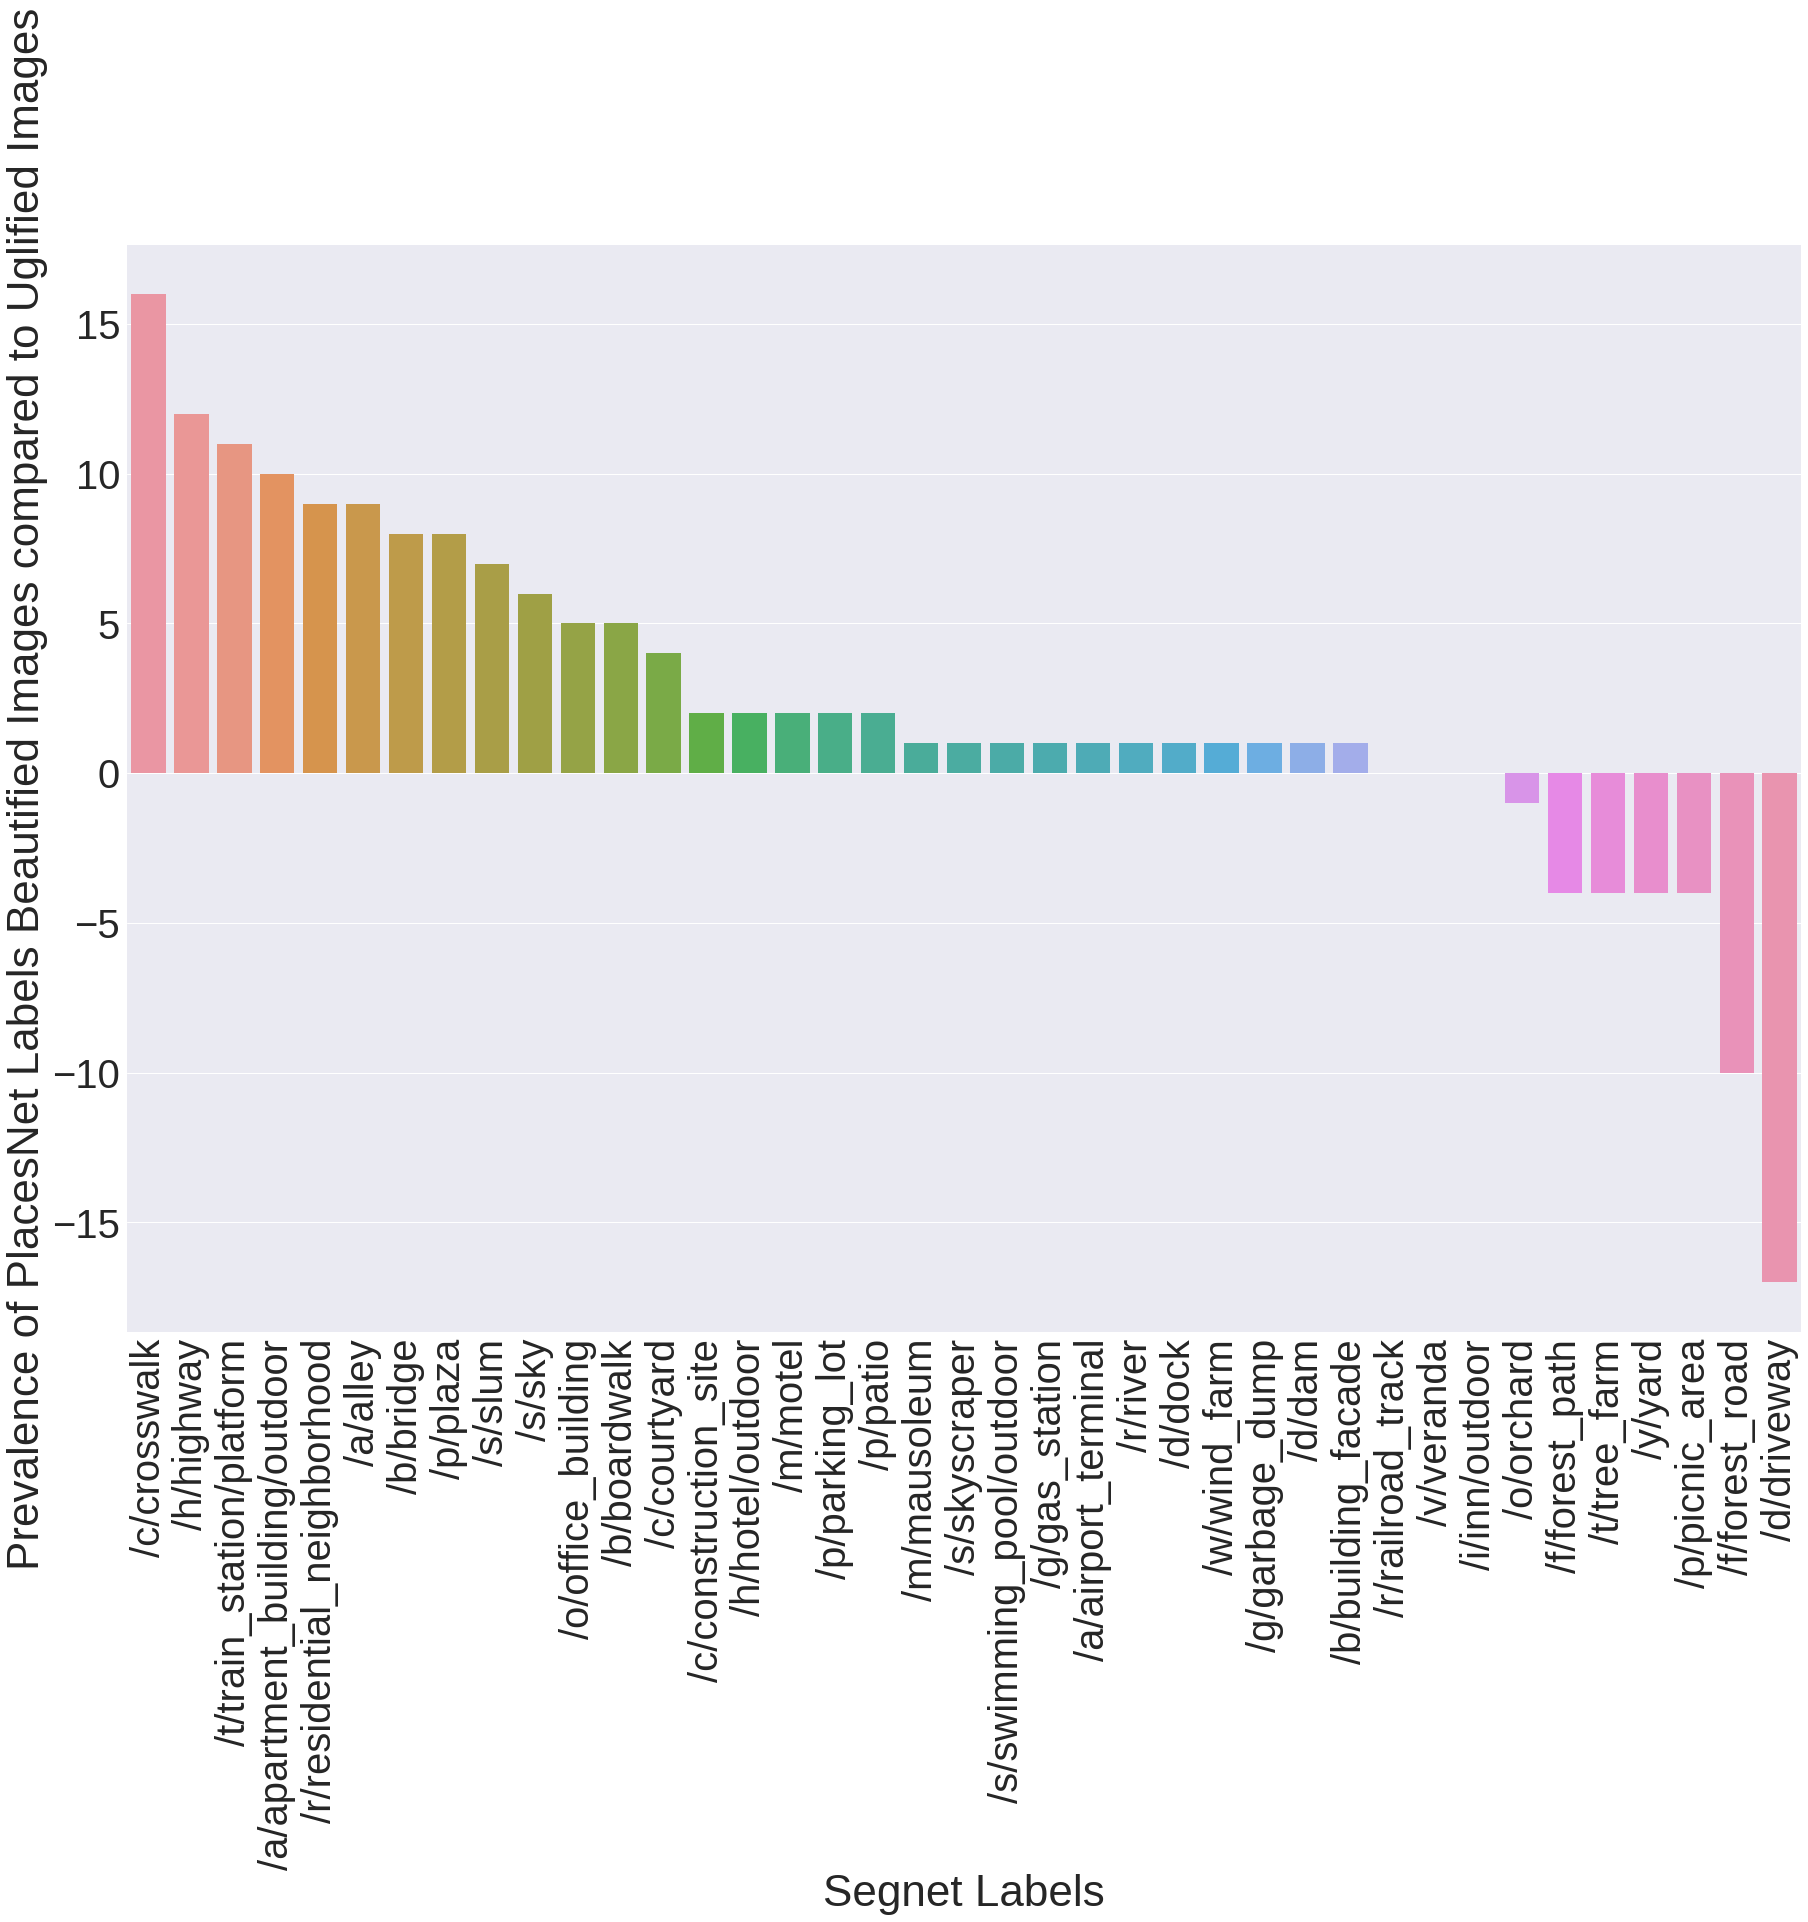

In [216]:
fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=4) 
sns.barplot(ax = ax , x=Xlabel, y=YFreq )
plt.xticks(rotation=90)
ax.set(xlabel='Segnet Labels', ylabel='Prevalence of PlacesNet Labels Beautified Images compared to Uglified Images')